![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark DUACS sea surface height maps

<div style="text-align: right"><i> 2023-04-27 DUACS_SSH_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of DUACS sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the DUACS system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [2]:
from glob import glob
import numpy as np
import os
import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append('../')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [4]:
import sys
sys.path.append('../')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [32]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'   
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
method_name = 'fdvarnet-glorys12v1-4th'
method_path = (
    '/Odyssey/private/p25denai/4dvarnet-starter/inference/data/mapping/4dvar-unetSolver-to4th.nc'
)
stat_output_filename = f'{output_dir}/stat_sla_{method_name}.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_{method_name}.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [22]:
ds_alg = xr.open_dataset('/Odyssey/public/altimetry_traces/2010_2019/gridded_0.25deg/ose_alg_daily_sla_0.25deg.nc').sel(time=slice(time_min, time_max))
ds_alg

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 364, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-30
  * latitude   (latitude) float32 3kB -90.0 -89.75 -89.5 ... 89.25 89.5 89.75
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    alg        (time, latitude, longitude) float64 3GB ...

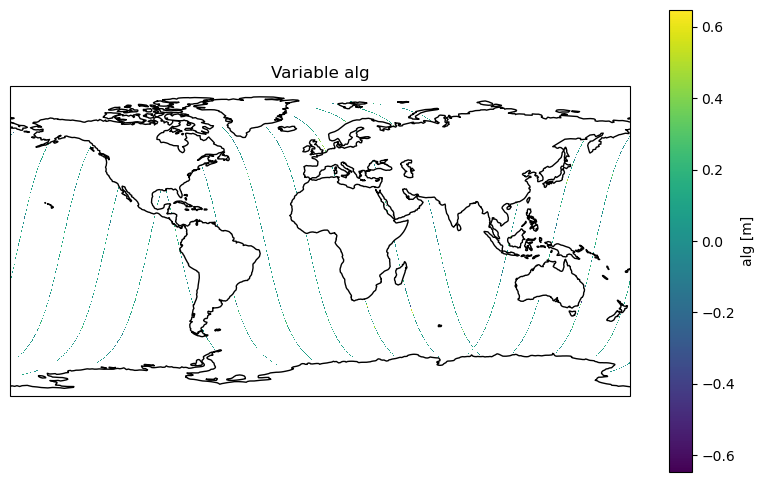

In [23]:
var = ds_alg["alg"]
var = ds_alg["alg"].isel(time=0)  # première date

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Créer une figure avec une projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot avec Cartopy
var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis")
ax.coastlines()  # ajouter les côtes
plt.title("Variable alg")
plt.show()

## Sea Level Anomalies maps to evaluate

In [37]:
%%time
# Load and process mapping
ds_maps = xr.open_dataset(method_path).sel(time=slice(time_min, time_max))
ds_maps

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'earthkit', 'gini', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

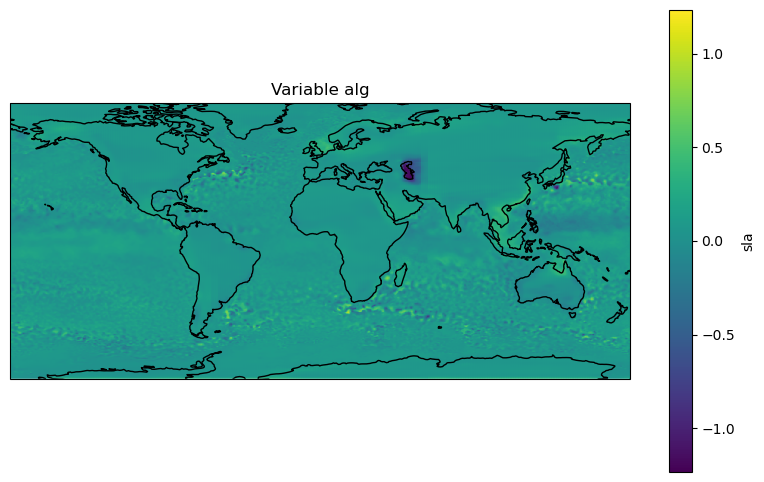

In [25]:
var = ds_maps["sla"]
var = ds_maps["sla"].isel(time=0)  # première date

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Créer une figure avec une projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot avec Cartopy
var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis")
ax.coastlines()  # ajouter les côtes
plt.title("Variable alg")
plt.show()

Créer de la cohérence spatiale

In [26]:
yc_min = max(ds_alg.latitude.min(), ds_maps.latitude.min())
yc_max = min(ds_alg.latitude.max(), ds_maps.latitude.max())
xc_min = max(ds_alg.longitude.min(), ds_maps.longitude.min())
xc_max = min(ds_alg.longitude.max(), ds_maps.longitude.max())


# Sélectionner la zone commune dans les deux Datasets
ds1_aligned = ds_alg.where(
    (ds_alg.latitude >= yc_min) & (ds_alg.latitude <= yc_max) &
    (ds_alg.longitude >= xc_min) & (ds_alg.longitude <= xc_max),
    drop=True
)

ds2_aligned = ds_maps.where(
    (ds_maps.latitude >= yc_min) & (ds_maps.latitude <= yc_max) &
    (ds_maps.longitude >= xc_min) & (ds_maps.longitude <= xc_max),
    drop=True
)


In [27]:
print("ds1_aligned :", ds1_aligned.dims, ds1_aligned.latitude.shape, ds1_aligned.longitude.shape)
print("ds2_aligned :", ds2_aligned.dims, ds2_aligned.latitude.shape, ds2_aligned.longitude.shape)

# Vérifier que les coordonnées sont identiques
print("yc identiques :", np.allclose(ds1_aligned.latitude, ds2_aligned.latitude))
print("xc identiques :", np.allclose(ds1_aligned.longitude, ds2_aligned.longitude))

ds1_aligned : FrozenMappingWarningOnValuesAccess({'time': 364, 'latitude': 640, 'longitude': 1440}) (640,) (1440,)
ds2_aligned : FrozenMappingWarningOnValuesAccess({'time': 365, 'latitude': 640, 'longitude': 1440}) (640,) (1440,)
yc identiques : True
xc identiques : True


<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-500km scale range. A bandpass filter is applied before calculating the scores.  

In [28]:
ds_merged = xr.merge([ds_alg.rename({"alg": "sla_unfiltered"}),
                      ds_maps.rename({"sla": "msla_interpolated"})])

# Forcer msla_interpolated à NaN là où sla_unfiltered est NaN
ds_merged["msla_interpolated"] = ds_merged["msla_interpolated"].where(
    ~ds_merged["sla_unfiltered"].isnull()
)
ds_merged['mapping_err'] = ds_merged['msla_interpolated'] - ds_merged['sla_unfiltered']
ds_merged

<xarray.Dataset> Size: 9GB
Dimensions:            (time: 365, latitude: 720, longitude: 1440)
Coordinates:
  * time               (time) datetime64[ns] 3kB 2019-01-01 ... 2019-12-31
  * latitude           (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75
  * longitude          (longitude) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
Data variables:
    sla_unfiltered     (time, latitude, longitude) float64 3GB nan nan ... nan
    msla_interpolated  (time, latitude, longitude) float64 3GB nan nan ... nan
    mapping_err        (time, latitude, longitude) float64 3GB nan nan ... nan

In [29]:

# On convertit en DataFrame
df = ds_merged[["sla_unfiltered", "msla_interpolated"]].to_dataframe().reset_index()
df = df.dropna(subset=["sla_unfiltered", "msla_interpolated"], how="any")
df = df.sort_values(["time", "latitude", "longitude"]).reset_index(drop=True)
df["offset"] = df.groupby("time").cumcount()

# On ajoute cet offset à l'horodatage
df["time_unique"] = df["time"] + pd.to_timedelta(df["offset"], unit="s")

# On garde les colonnes finales
df_final = df[["time_unique", "latitude", "longitude", "sla_unfiltered", "msla_interpolated"]]

df_final = df_final.rename(columns={
    "time_unique": "time"
})

ds_interp = df_final.set_index(["time"]).to_xarray()

ds_interp

<xarray.Dataset> Size: 169MB
Dimensions:            (time: 4701226)
Coordinates:
  * time               (time) datetime64[ns] 38MB 2019-01-01 ... 2019-12-30T0...
Data variables:
    latitude           (time) float64 38MB -78.25 -78.0 -78.0 ... 80.25 80.25
    longitude          (time) float32 19MB 184.8 185.0 185.2 ... 8.75 9.0 9.25
    sla_unfiltered     (time) float64 38MB 0.19 0.16 0.136 ... 0.093 0.148 0.13
    msla_interpolated  (time) float64 38MB 0.03238 0.02636 ... 0.1177 0.1083

In [30]:
ds_interp['lwe'] = 0
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename,method_name)

ds_interp['mapping_err'] = ds_interp['msla_interpolated'] - (ds_interp['sla_unfiltered'] - ds_interp['lwe'])
    
print('Total RMSE=',np.sqrt(np.mean(ds_interp['mapping_err'].values**2)),'m') 
print('Total RMSE score=',1-np.sqrt(np.mean(ds_interp['mapping_err'].values**2))/np.sqrt(np.mean((ds_interp['sla_unfiltered'] - ds_interp['lwe']).values**2)),'m')   

2025-09-24 15:16:42 INFO     Compute mapping error all scales
2025-09-24 15:16:42 INFO     Compute mapping error for scales between 65.0 and 500.0 km


Total RMSE= 0.039347619134289295 m
Total RMSE score= 0.7042265827532193 m


2025-09-24 15:16:42 INFO     Compute binning statistics
2025-09-24 15:16:47 INFO     Compute statistics by oceanic regime
2025-09-24 15:16:58 INFO     Stat file saved as: ../results/stat_sla_fdvarnet-glorys12v1-4th.nc


Total RMSE= 0.039347619134289295 m
Total RMSE score= 0.7042265827532193 m


```
Total RMSE= 0.039786029332299196 m
Total RMSE score= 0.6929505087058931 m
```

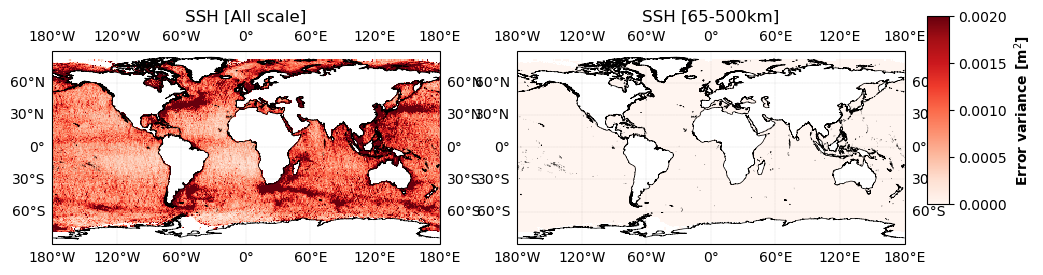

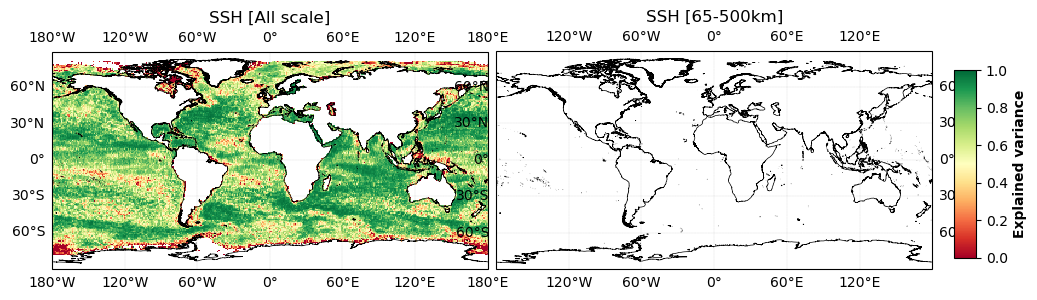

In [26]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename)

In [ ]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [ ]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.002074,0.007916,0.000477,0.001784,0.738039,0.732511
offshore_highvar,0.002874,0.053268,0.000980,0.021747,0.946048,0.954950
offshore_lowvar,0.001197,0.006298,0.000244,0.001785,0.809914,0.863251
equatorial_band,0.001346,0.005907,0.000323,0.000518,0.772046,0.375803
arctic,0.001622,0.003858,0.000301,0.000608,0.579467,0.505238
antarctic,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
plot_stat_by_regimes(stat_output_filename)[['var_score_allscale', 'var_score_filtered']]

,var_score_allscale,var_score_filtered
coastal,0.702557,NaN
offshore_highvar,0.948103,NaN
offshore_lowvar,0.838986,NaN
equatorial_band,0.808396,NaN
arctic,0.505560,NaN
antarctic,0.326694,NaN
